# PART 1

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('Student Depression Dataset.csv')
print(data.info())
print(data.describe())

# Separate categorical and numerical columns
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = data.select_dtypes(include=['object']).columns

# Fill missing values for numerical columns with the median
data[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].median())

# Fill missing values for categorical columns with the mode
for col in categorical_columns:
    data[col].fillna(data[col].mode()[0], inplace=True)

# correlations between features
plt.figure(figsize=(10, 8))  
sns.heatmap(data[numerical_columns].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Features", fontsize=16)
plt.tight_layout()
plt.show()

# Scatterplot between 'Academic Pressure' and 'Depression'
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Academic Pressure', y='Depression', data=data, color='green', s=80, edgecolor='black')
plt.title("Academic Pressure vs Depression", fontsize=16)
plt.xlabel("Academic Pressure", fontsize=14)
plt.ylabel("Depression (0 = No, 1 = Yes)", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

# Histogram for 'Age'
plt.figure(figsize=(8, 6))
sns.histplot(data['Age'], kde=True, color='skyblue', bins=20)
plt.title("Distribution of Age", fontsize=16)
plt.xlabel("Age", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.tight_layout()
plt.show()

# Pairplot to check relationships between multiple numerical features
sns.pairplot(data[['Age', 'CGPA', 'Academic Pressure', 'Work Pressure', 'Financial Stress']])
plt.suptitle("Pairplot of Key Features", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = data.select_dtypes(include=['object']).columns

data[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].median())

for col in categorical_columns:
    data[col] = data[col].fillna(data[col].mode()[0])

data = data.drop(columns=['Student'], errors='ignore')  

cols_to_encode = [c for c in ['Gender', 'City', 'Degree'] if c in data.columns]
if cols_to_encode:
    data = pd.get_dummies(data, columns=cols_to_encode, drop_first=True)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data[['Age', 'CGPA']] = scaler.fit_transform(data[['Age', 'CGPA']])


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve

cols_to_dummy = [
	c for c in ['Profession', 'Sleep Duration', 'Dietary Habits',
				'Have you ever had suicidal thoughts ?',
				'Family History of Mental Illness']
	if c in data.columns and data[c].dtype == 'object'
]

if cols_to_dummy:
	data = pd.get_dummies(data, columns=cols_to_dummy, drop_first=True)

data = data.drop(columns=['id'], errors='ignore')

X = data.drop('Depression', axis=1)
y = data['Depression']

X = X.select_dtypes(include=['number', 'bool'])

# training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Logistic Regression model 
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.show()

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Precision, Recall, F1-Score
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")


# PART 2

## TASK 1
#### 1) Precision increases when you make fewer false positives, i.e., fewer non-depressed students being classified as depressed.
####  Recall increases when you make fewer false negatives, i.e., more depressed students being correctly classified as depressed.
#### Lowering the threshold increases recall but may hurt precision (more false positives). Raising the threshold improves precision but may reduce recall (more false negatives). The goal is to find a balance between these two metrics.


In [39]:
# 2)
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Function to compute metrics at different thresholds
def compute_metrics_at_thresholds(y_true, y_pred_prob, thresholds):
    metrics = []
    for threshold in thresholds:
        y_pred = (y_pred_prob >= threshold).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        metrics.append({
            'Threshold': threshold,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp
        })
    return pd.DataFrame(metrics)

# Define a range of thresholds (0 to 1 in steps of 0.01)
thresholds = np.arange(0.0, 1.0, 0.01)

y_pred_prob = model.predict(X_test)

metrics_df = compute_metrics_at_thresholds(y_test, y_pred_prob, thresholds)

metrics_df.head()


,Threshold,Precision,Recall,F1,TN,FP,FN,TP
0,0.00,0.580183,1.000000,0.734324,0,2343,0,3238
1,0.01,0.850540,0.875232,0.862709,1845,498,404,2834
2,0.02,0.850540,0.875232,0.862709,1845,498,404,2834
3,0.03,0.850540,0.875232,0.862709,1845,498,404,2834
4,0.04,0.850540,0.875232,0.862709,1845,498,404,2834


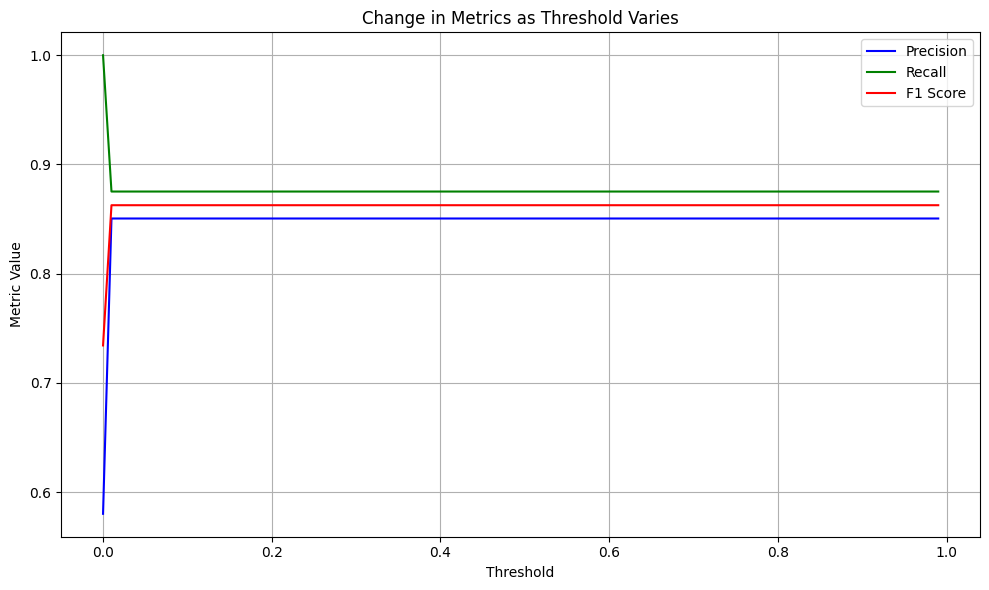

In [40]:
# 3)

plt.figure(figsize=(10, 6))

# Plot Precision, Recall, and F1
plt.plot(metrics_df['Threshold'], metrics_df['Precision'], label='Precision', color='blue')
plt.plot(metrics_df['Threshold'], metrics_df['Recall'], label='Recall', color='green')
plt.plot(metrics_df['Threshold'], metrics_df['F1'], label='F1 Score', color='red')

plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Change in Metrics as Threshold Varies')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 4) 
#### -As you lower the threshold (move left on the x-axis), recall increases, meaning more depressed students are identified.
#### -As you raise the threshold, precision increases because fewer non-depressed students are misclassified as depressed.
#### -F1 score typically shows the balance between recall and precision. The threshold that maximizes F1 is usually the most optimal one for classification.

### 5) 
#### We already created the plots in the previous step, so just make sure to include interpretations of the trends you see in the Precision, Recall, and F1 curves.

### 6)
#### The optimal threshold typically maximizes the F1 score, balancing both recall and precision. You could also use a ROC curve or Youden's index to find the optimal threshold.


## TASK 2

### 1) 
#### -True Positive (TP): Correctly predicted depression. Cost = $500
#### -False Positive (FP): Incorrectly predicted depression. Cost = $1000
#### -True Negative (TN): Correctly predicted no depression. Cost = $0
#### -False Negative (FN): Incorrectly predicted no depression. Cost = $5000
Why is TN much lower? Because no action is needed when no depression is predicted, while a false prediction (FP or FN) incurs higher costs due to the actions involved (hospital visits, etc.).

In [41]:
# 2)
# Cost for each type of prediction
cost_tp = 500    # True Positive cost
cost_fp = 1000   # False Positive cost
cost_tn = 0      # True Negative cost
cost_fn = 5000   # False Negative cost

# Calculate the total cost for each threshold
def compute_cost_at_thresholds(y_true, y_pred_prob, thresholds):
    costs = []
    for threshold in thresholds:
        y_pred = (y_pred_prob >= threshold).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        total_cost = (tp * cost_tp) + (fp * cost_fp) + (tn * cost_tn) + (fn * cost_fn)
        costs.append({
            'Threshold': threshold,
            'Total Cost': total_cost
        })
    return pd.DataFrame(costs)

cost_df = compute_cost_at_thresholds(y_test, y_pred_prob, thresholds)

cost_df.head()


,Threshold,Total Cost
0,0.00,3962000
1,0.01,3935000
2,0.02,3935000
3,0.03,3935000
4,0.04,3935000


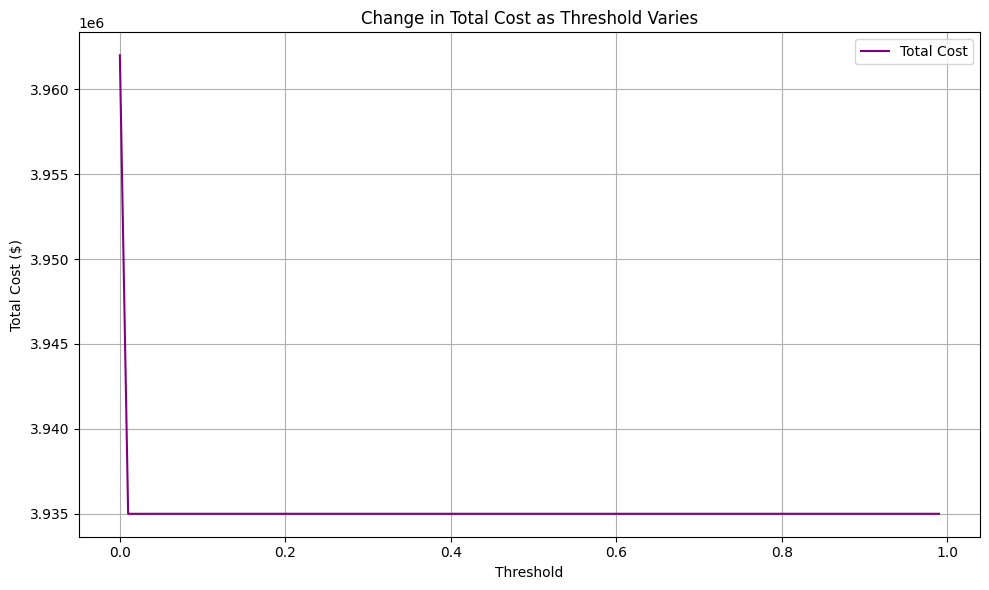

In [42]:
# 3)
plt.figure(figsize=(10, 6))

# Plot Total Cost vs Threshold
plt.plot(cost_df['Threshold'], cost_df['Total Cost'], label='Total Cost', color='purple')

plt.xlabel('Threshold')
plt.ylabel('Total Cost ($)')
plt.title('Change in Total Cost as Threshold Varies')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [43]:
# 4)
# Find the threshold that minimizes the total cost
optimal_threshold = cost_df.loc[cost_df['Total Cost'].idxmin()]

print(f'Optimal threshold: {optimal_threshold["Threshold"]}')

Optimal threshold: 0.01


## TASK 3

### 1)
##### The key hyperparameters for Logistic Regression include:
C: Regularization strength (inverse). A smaller value means more regularization (less overfitting).

solver: Algorithm used for optimization. Options are:                       
-'liblinear': Good for small datasets and when using L1 regularization.                                             
-'lbfgs', 'newton-cg', 'saga': Suitable for large datasets and multi-class classification.

max_iter: Maximum number of iterations for the solver to converge.

penalty: Type of regularization (L1, L2, or None).

In [44]:
# 2)
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()

# Set up a parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10],            # Regularization strength
    'solver': ['liblinear', 'lbfgs'],  # solvers that work with both penalties
    'max_iter': [100, 200],       # Max iterations
    'penalty': ['l2']             # Only use L2 for lbfgs solver, or 'l1' for liblinear
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print(f'Best hyperparameters: {grid_search.best_params_}')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best hyperparameters: {'C': 0.1, 'max_iter': 200, 'penalty': 'l2', 'solver': 'lbfgs'}


In [45]:
# 3)
# Retrain the logistic regression model with the best hyperparameters
best_model = grid_search.best_estimator_

y_pred_best = best_model.predict(X_test)

accuracy_best = accuracy_score(y_test, y_pred_best)
print(f'Optimized Model Accuracy: {accuracy_best:.4f}')


Optimized Model Accuracy: 0.8378


## TASK 4


                                       Feature  Coefficient  Abs Coefficient
107  Have you ever had suicidal thoughts ?_Yes     2.510518         2.510518
106                   Dietary Habits_Unhealthy     1.038936         1.038936
1                            Academic Pressure     0.845713         0.845713
7                             Financial Stress     0.559838         0.559838
0                                          Age    -0.556644         0.556644


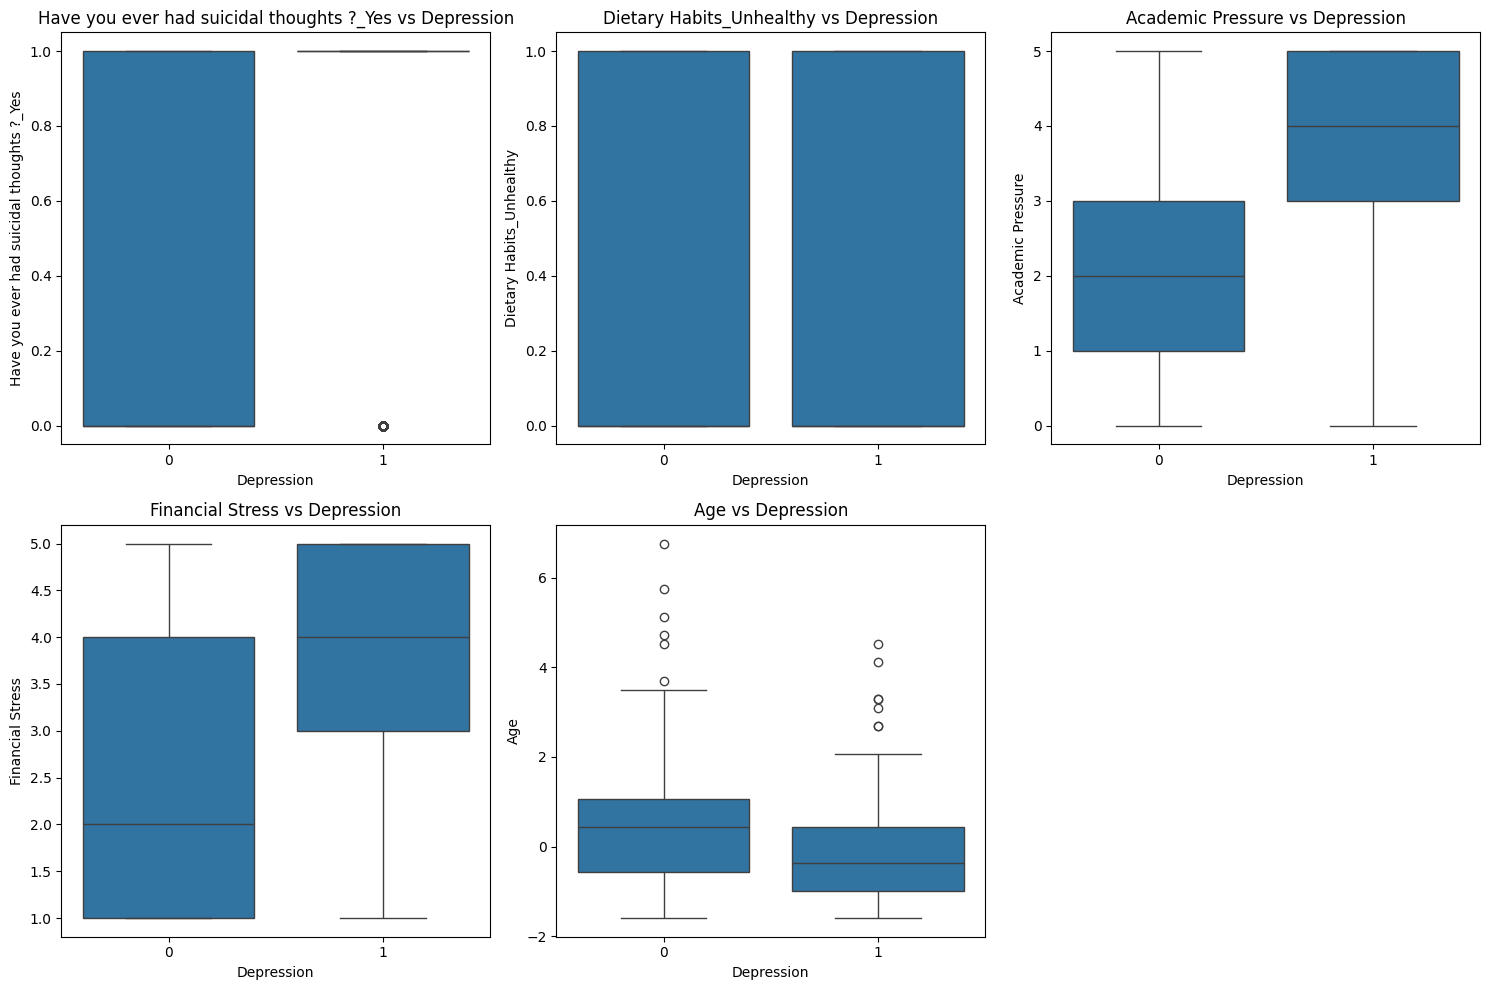

In [46]:
# Get the coefficients (weights) from the best logistic regression model
coefficients = best_model.coef_[0]

# Create a DataFrame with feature names and their corresponding coefficients
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients
})

# Rank features by the absolute value of the coefficients (strongest impact)
feature_importance['Abs Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs Coefficient', ascending=False)

# Display the top 5 features with the largest absolute coefficients
top_features = feature_importance.head(5)
print(top_features)

# Filter the data for the top 5 most important features
top_feature_names = top_features['Feature'].tolist()

# Combine the features and target into one DataFrame for plotting
data_for_plot = pd.concat([X_train[top_feature_names], y_train], axis=1)

# Create boxplots for the top 5 features, compared to 'depression' (target variable)
plt.figure(figsize=(15, 10))
for i, feature in enumerate(top_feature_names):
    plt.subplot(2, 3, i + 1)  # Adjust grid layout 
    sns.boxplot(x='Depression', y=feature, data=data_for_plot)
    plt.title(f'{feature} vs Depression')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


### 1)
#### 1. What distinguishes depressed from non-depressed students?
Features with significant differences: Features where the boxplots show clear separation between the two classes (depressed vs. non-depressed). For example, features like academic pressure and financial stress may show much higher values for depressed students compared to non-depressed ones.

Outliers: If you observe outliers in certain features (e.g., very high values for work pressure or study satisfaction in the depressed group), it may suggest that these extreme values are tied to depression.

#### 2. Why does the model sometimes misclassify non-depressed students as depressed?
Overlap in feature distributions: Features like academic pressure or financial stress may have a wide range for both depressed and non-depressed students, making it harder for the model to distinguish between them accurately.

Imbalanced classes: If the dataset is imbalanced (more non-depressed students than depressed ones), the model may be biased toward predicting the majority class (non-depressed). Adjusting for class imbalance (e.g., using weighted loss or sampling techniques) can help address this.

#### 3. Why does the model miss some depressed students?
Insufficient signal from features: The features that are available may not capture all the nuances of depression. For example, sleep duration might not be a strong enough indicator on its own for predicting depression, even though it's correlated in some cases.

Threshold choice: If the decision threshold is set too high (e.g., predicting depression only if the model's predicted probability is above 0.8), some depressed students with lower predicted probabilities might be missed. Lowering the threshold could help capture more of the depressed cases, at the cost of precision.

#### The top 5 features that have the most significant impact on depression predictions were selected based on the model coefficients. These features have the largest absolute coefficients, indicating that changes in their values have a stronger effect on the model's prediction of depression.

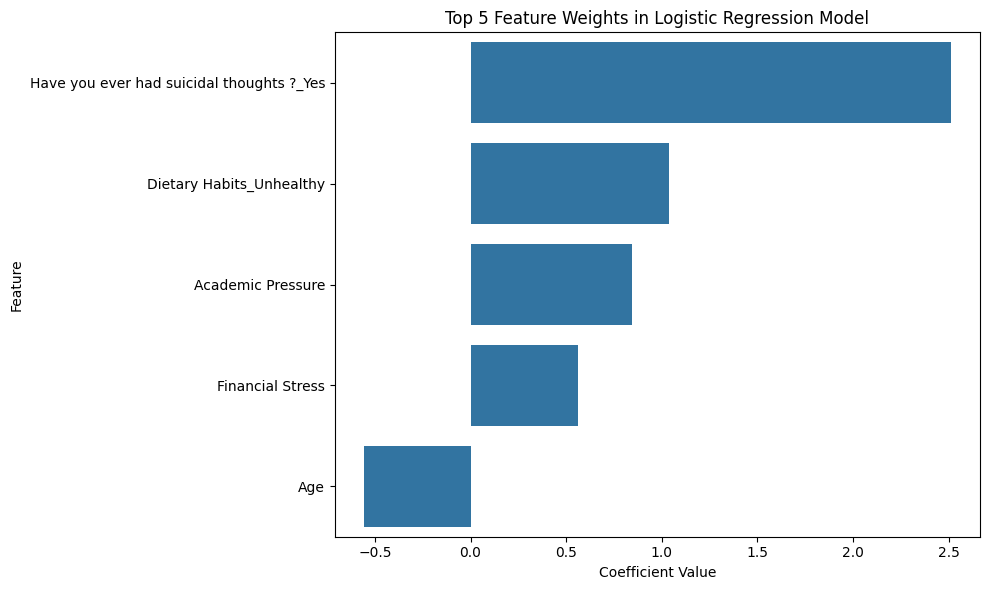

In [47]:
# Sort features by their absolute coefficient values
sorted_features = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients
})
sorted_features['Abs Coefficient'] = sorted_features['Coefficient'].abs()
sorted_features = sorted_features.sort_values(by='Abs Coefficient', ascending=False)

# Display the top 5 features with the largest absolute coefficients
top_features = sorted_features.head(5)

# Plot only the top 5 features based on their coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=top_features)
plt.xlabel('Coefficient Value')
plt.title('Top 5 Feature Weights in Logistic Regression Model')
plt.tight_layout()
plt.show()


Positive Coefficients: Features with positive coefficients increase the likelihood of the student being predicted as depressed. For example, if "Academic Pressure" has a large positive coefficient, it means higher academic pressure is associated with an increased likelihood of depression.

Negative Coefficients: Features with negative coefficients decrease the likelihood of depression. If "CGPA" has a negative coefficient, it suggests that higher academic performance reduces the likelihood of depression.

Magnitude of Coefficients: The larger the absolute value of the coefficient, the more influential the feature is in predicting depression. Features with the largest coefficients (in absolute value) are the most important predictors.

The bar chart will show you which features are most influential based on their coefficients. The largest bars (either positive or negative) represent the most influential features for the prediction of depression.

From the coefficients plot, we can interpret:                   
-Which features have the strongest positive or negative association with depression.                
-Which features are most influential in predicting depression based on the size of their coefficients.